<a href="https://colab.research.google.com/github/umeshrawat/MachineLearning/blob/master/Unsupervised_Classification/SocialClusters/src/SocialClustersPyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

********************************************************************************

Full Name: Umesh Rawat

Email Address: umeshrawat@gmail.com

Problem Statement: ClusterQuest: Unveiling Cohorts in Social Networks.

********************************************************************************

ReadMe.

1. The raw data set is a list of edges between nodes.
2. The code below applies clustering algorithms and follows this approach for each of the application:

  a. Load the dataset.

  b. Do Feature Engineering,

  c. Apply modelling technique(s) to cluster the data,

  d. Evaluate their performance.

  e. Conclude by visualizing and summarizing the results of the modelling techniques.


********************************************************************************

This notebook uses the following features and implements modelling techniques on them to cluster the social network in the following manner:

1. **Degree and Cluster Coefficient Centrality Measure** : In order to cluster the social network based on "close-knitness" amongst users within the clusters. Helps to use clusters for "**Community Engagement**" business requirements.

2. **2, 3 hops Mean neighbor Centrality Measure**: Clusters based on Average degree value of each user in the social network. Helps to use clusters for "**Community Engagement", "Influencer Identification"**.

3. **Eigen Vector Centrality and Ego Graph Measure**: Eigen Vector centrality measure helps to cluster based on how "Well-connected" a user is within the social network. Helps to use clusters for "**Influencer Identification**" business requirement. **Ego Graph**: Helps to analyse local neighborhood around a specific user. Helps to understand the immediate connections and network structure around individual user. Similar to knowing Cluster Coefficients centrality measure, Ego graph helps to know Cohesion between users and their neighbors. Helps in "**Influencer Identification**" business requirements.

5. Finally, Combine all above measures and cluster the social network to understand how different are clustering results when used together.

6. We will then use **Node2Vec algorithm, DBSCAN algorithm and Hierarchical algorithm** on this social network data to understand how well can they analyse the social network data.

7. In the future, we can add more centrality measures like:
  a. Closeness Centrality: How many steps does a node take to reach every other node in the network? Measures the "closeness" of a node with every other node in the network.
  b. Betweenness Centrality: Measures if a node is a 'bridge' between differnt clusters. How often does a node appear in the shortest paths between other nodes? Helps to find those nodes that become connections between different groups of nodes within a network.
  c. Other measures like Katz Centrality, PageRank, Percolation Centrality, Subgraph Centrality and Harmonic Centrality

********************************************************************************

First, Load the dataset.

********************************************************************************

In [3]:
!git clone https://github.com/umeshrawat/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 541 (delta 122), reused 263 (delta 91), pack-reused 208
Receiving objects: 100% (541/541), 23.33 MiB | 21.98 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [4]:
# set the root path of the dataset.
root_folder_path = '/content/MachineLearning/Unsupervised_Classification/SocialClusters/Dataset/facebook_combined.txt'

In [3]:
!pip install node2vec
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

In [5]:
# Load the raw dataset into a Graph object.
import networkx as nx

nx_graph = nx.read_edgelist(root_folder_path, create_using = nx.Graph(), nodetype = int)
print(nx_graph)

Graph with 4039 nodes and 88234 edges


********************************************************************************

Next, Check the raw data set for any self-directed users.

********************************************************************************

In [5]:
import igraph as ig

# Count the number of self-loop edges in NetworkX
num_self_joints = sum(1 for u, v in nx_graph.edges() if u == v)

print(num_self_joints)

0


--> No self-joint (self-directed) nodes in the data set. That is, each user is connected to at least one other user at the minimum.

********************************************************************************

Now, we will begin with Feature Engineering and Modelling stages.

********************************************************************************

**1. Degree and Cluster Coefficient Centrality Measure.**

In [7]:
import pandas as pd

# Calculate node features
degree_centrality = nx.degree_centrality(nx_graph)
clustering_coefficient = nx.clustering(nx_graph)

# Create DataFrame
df_nodes = pd.DataFrame({
    'Node': list(nx_graph.nodes()),
    'Degree_Centrality': [degree_centrality[node] for node in nx_graph.nodes()],
    'Clustering_Coefficient': [clustering_coefficient[node] for node in nx_graph.nodes()]
})

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(df_nodes.describe())

            Node  Degree_Centrality  Clustering_Coefficient
count 4039.00000         4039.00000              4039.00000
mean  2019.00000            0.01082                 0.60555
std   1166.10320            0.01298                 0.21446
min      0.00000            0.00025                 0.00000
25%   1009.50000            0.00272                 0.46667
50%   2019.00000            0.00619                 0.60000
75%   3028.50000            0.01412                 0.75238
max   4038.00000            0.25879                 1.00000


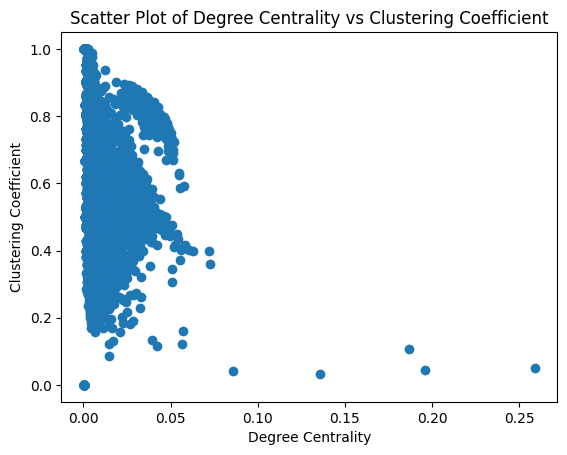

In [9]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(degree_centrality.values(), clustering_coefficient.values())
plt.xlabel('Degree Centrality')
plt.ylabel('Clustering Coefficient')
plt.title('Scatter Plot of Degree Centrality vs Clustering Coefficient')
plt.show()

In [ ]:
# Group by degree and clustering coefficient and count nodes
node_counts = df_nodes.groupby(['Degree_Centrality', 'Clustering_Coefficient'])['Node'].count().reset_index(name='Count').sort_values('Degree_Centrality', ascending=False)

print(node_counts)

      Degree_Centrality  Clustering_Coefficient  Count
2782            0.25879                 0.04904      1
2781            0.19614                 0.04477      1
2780            0.18697                 0.10549      1
2779            0.13546                 0.03223      1
2778            0.08593                 0.04196      1
2777            0.07281                 0.35992      1
2776            0.07207                 0.39964      1
2775            0.06290                 0.39968      1
2774            0.06067                 0.40204      1
2773            0.05820                 0.41651      1
2772            0.05795                 0.59330      1
2771            0.05795                 0.41158      1
2770            0.05721                 0.16164      1
2769            0.05671                 0.12304      1
2768            0.05597                 0.40138      1
2767            0.05547                 0.58736      1
2766            0.05523                 0.37058      1
2765      

**OBSERVATION:**

Above measure values and scatter plot shows that:

1. With average Cluster Coefficient value of 0.60555, it shows that the clusters have "Close-knit neighbors" or in other words, users have "close-knit" relations with their immediate neighbors.

2. There is only 1 user in the network who has the highest value of 0.25879 as Degree measure. Low Degree centrality shows that the network doesn't contain users that are centroids of large clusters. Potentially, this network contains clusters with users with high degrees within each of those sub-clusters.

3. Overall, the users have close-knit relationships with their immediate neighbors within clusters.

Let's cross validate this observation as a graph plot:

In [12]:
import matplotlib.pyplot as plt

def plot_centrality_distribution(centrality_data: dict, centrality_name: str):
  plt.figure(figsize=(10, 6))
  pos = nx.spring_layout(nx_graph)  # Choose a layout for the graph
  node_sizes = [centrality_data[node] * 100 for node in nx_graph.nodes()]
  # Draw the graph with node sizes and labels
  plt.figure(figsize=(10, 10))  # Adjust figure size as needed
  nx.draw_networkx_nodes(nx_graph, pos, node_size=node_sizes, node_color='red')
  nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
  nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_color='blue')

  plt.title("Graph Visualization: " + centrality_name )
  plt.axis('off')  # Turn off axis
  plt.show()

<Figure size 1000x600 with 0 Axes>

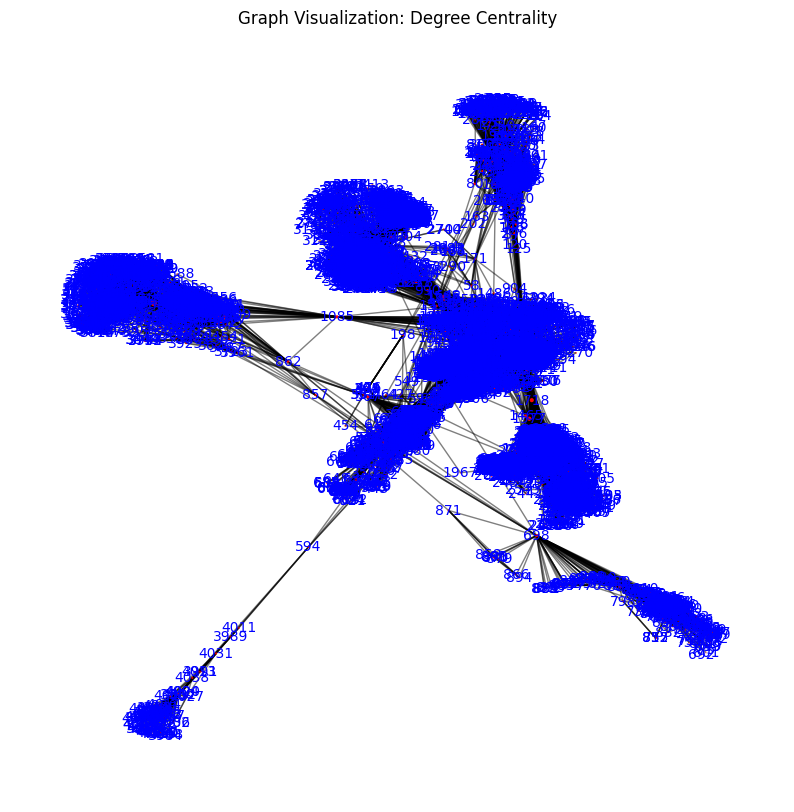

<Figure size 1000x600 with 0 Axes>

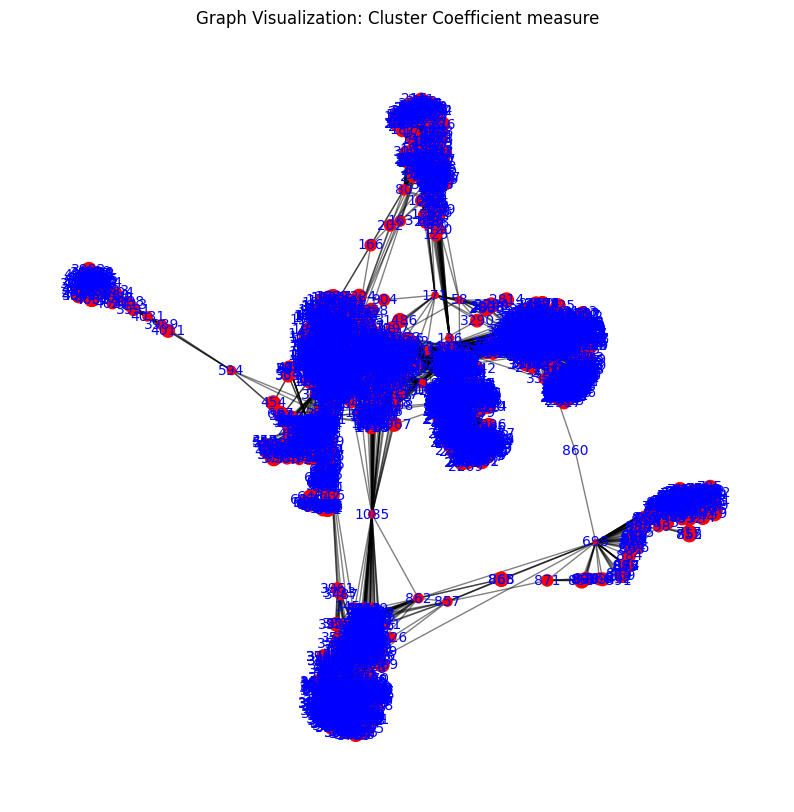

In [12]:
#Plot Centrality measures
plot_centrality_distribution(degree_centrality, "Degree Centrality")
plot_centrality_distribution(clustering_coefficient, "Cluster Coefficient measure")

These two visualizations corroborate the observations:
1. In general, users aren't connected to all other users. They are part of sub clusters of users based on their immediate neighbors and closeness of their connections.
2. Connections are strong - Immediate neighbors are close to each other.
3. Based on degree of connections, network can be divided into 7 clusters, and into 7 clusters based solely on the Cluster coefficient measure.

Next, We will use K-Means classification algorithm to model the clustering based on these 2 measures.

In [13]:
socialClusterDataFrame = pd.DataFrame()

In [14]:
from sklearn.cluster import KMeans

socialClusterDataFrame = df_nodes[['Degree_Centrality', 'Clustering_Coefficient']]

# Initialize the KMeans model with the desired number of clusters  = 7
kmeans = KMeans(n_clusters=7, random_state=42)

# Fit the model to your data
kmeans.fit(socialClusterDataFrame)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Add the cluster labels to your dataframe
socialClusterDataFrame['cluster'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
socialClusterDataFrame.groupby('cluster').describe()

Degree_Centrality                                                  \
                    count    mean     std     min     25%     50%     75%   
cluster                                                                     
0               943.00000 0.01229 0.01043 0.00099 0.00421 0.00867 0.01795   
1               635.00000 0.01403 0.01586 0.00099 0.00272 0.00520 0.02402   
2               390.00000 0.01035 0.00834 0.00149 0.00471 0.00780 0.01337   
3               817.00000 0.01006 0.01011 0.00074 0.00322 0.00619 0.01362   
4               459.00000 0.00198 0.00258 0.00050 0.00074 0.00124 0.00223   
5               708.00000 0.01267 0.01172 0.00124 0.00471 0.00892 0.01610   
6                87.00000 0.01226 0.04318 0.00025 0.00025 0.00025 0.00025   

                Clustering_Coefficient                                  \
            max                  count    mean     std     min     25%   
cluster                                                                  
0       0.05795              943.00000 0.55085 0.03395 0.49351 0.52381   
1       0.05002              635.00000 0.80336 0.03910 0.73672 0.76923   
2       0.07281              390.00000 0.29703 0.05093 0.15630 0.26587   
3       0.05498              817.00000 0.66863 0.03564 0.61000 0.63772   
4       0.02798              459.00000 0.96913 0.04055 0.88843 0.93333   
5       0.07207              708.00000 0.43543 0.03469 0.36615 0.40875   
6       0.25879               87.00000 0.01131 0.03288 0.00000 0.00000   

                                 
            50%     75%     max  
cluster                          
0       0.54971 0.58049 0.60983  
1       0.80000 0.83333 0.88462  
2       0.30560 0.33701 0.36575  
3       0.66667 0.69799 0.73626  
4       1.00000 1.00000 1.00000  
5       0.43598 0.46667 0.49311  
6       0.00000 0.00000 0.13518

**Interpretation:**

(PS: On Rerunning the K-means, the cluster Id could change for below analysis)


For the entire graph,
The mean Degree centrality measure is: 0.01082,
mean Cluster Coefficient is:           0.60555

1. Clusters 0,1,2,4 contains average degree greater than the network's mean.
These clusters comprise of 2387 users.

2. Clusters 3,5,6 contain the remaining number of users with low average degree.
These clusters have 1652 users.

3. Clusters 0,3,6 have mean Cluster Coefficient higher than network's average.

4. Clusters 1,2,4,5 have mean Cluster Coefficient lower than network's average.

Cluster 0 contains 630 users: High degree of neighbors, High closeness with neighbors.

Cluster 1 contains 779 users: High degree of neighbors, Low closeness with neighbors.

Cluster 2 contains 889 users: High degree of neighbors, Low in closeness with Neighbors.

Cluster 3 contains 459 users: Low degree of neighbors, High in closeness with neighbors.

Cluster 4 contains 89 users: High degree of neighbors, Low in closeness with Neighbors.

Cluster 5 contains 412 users: Low degree of neighbors, Low in closeness with neighbors.

Cluster 6 contains 781 users: Low degree of neighbors, High in closeness.

2 Groups can be formed from above observations:

**Group A**: Users base within Tightly-Knit local cluster.

Contains 4 Clusters: 0,3,6.

Total number of users: 1870.

**Group B**: Remaining users with low "closeness".

Contains 3 Clusters: 1,2,4,5.

Total numbers of Users: 2169

--> ANALYSIS: These **1870 users** in Group A can be used for marketing of products or services that leverages the genuine, close-knit connections between neighbors.


Next, Let's use the evaluation scores to confirm K-Means algorithm's effectiveness:


1. Elbow plot - To know how many clusters are appropriate for the graph data. The value from which the rate of change of inertia slows down significantly, is the optimal number of clusters.
2. Silhouette Score - To know how well seperated each node is from its own cluster compared to other clusters. Range of score from -1, 0, 1 where -1 indicates incorrect clustering, 0 indicates that the node is close to the boundary between two clusters, and close to 1 indicates that the node is well-seperated from other clusters.
3. Calinski-Harabasz Score - Score based on the ratio of of between-cluster dispersion to within-cluster dispersion. A higher score indicates better-defined and separated clusters.
4. Davies-Bouldin Score - Measures the average similarity between each cluster and its most similar cluster. A lower score suggestss that the clusters are more compact and well-seperated.

for k values in the range 2 to 10.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2, Inertia: 68.67374028663426, Silhouette Score: 0.5494747299820967, Calinski-Harabasz score: 6920.840486367249, Davies-Bouldin score: 0.6107400359459885


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 3, Inertia: 35.508050595545484, Silhouette Score: 0.5323890713439415, Calinski-Harabasz score: 8576.124058774925, Davies-Bouldin score: 0.5861088850172683


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4, Inertia: 22.02141129583973, Silhouette Score: 0.5187497047939063, Calinski-Harabasz score: 10040.09428958265, Davies-Bouldin score: 0.5813042252670982


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5, Inertia: 14.3235209982468, Silhouette Score: 0.5268504319817409, Calinski-Harabasz score: 12116.043583356937, Davies-Bouldin score: 0.5297204063603526


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 6, Inertia: 9.160014516206648, Silhouette Score: 0.5391113916814156, Calinski-Harabasz score: 15607.568548304871, Davies-Bouldin score: 0.49137327075553644


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7, Inertia: 6.430508245329573, Silhouette Score: 0.5365645678813159, Calinski-Harabasz score: 18808.345239107206, Davies-Bouldin score: 0.4889402178369345


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 8, Inertia: 4.930233747082137, Silhouette Score: 0.5290742567711144, Calinski-Harabasz score: 21200.676441552147, Davies-Bouldin score: 0.5031115074229328


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9, Inertia: 3.960320307142232, Silhouette Score: 0.5220342981511562, Calinski-Harabasz score: 23206.954570299342, Davies-Bouldin score: 0.5298617850436002


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 10, Inertia: 3.2609407809949644, Silhouette Score: 0.5162364923817521, Calinski-Harabasz score: 25143.040463387533, Davies-Bouldin score: 0.5378198677748897


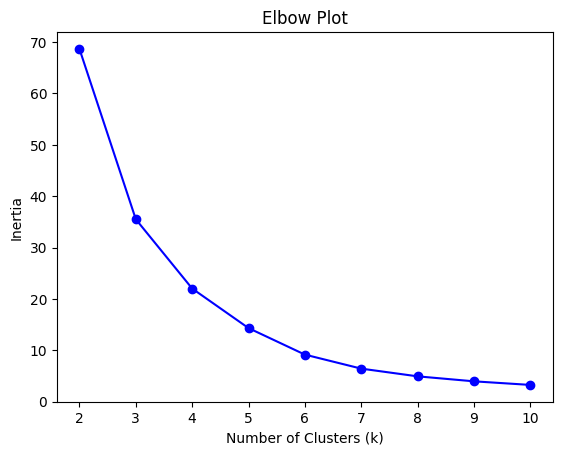

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

socialClusterDataFrame = df_nodes[['Degree_Centrality', 'Clustering_Coefficient']]

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
for k in range(2, 11):  # Check for k from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(socialClusterDataFrame)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(socialClusterDataFrame, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(socialClusterDataFrame, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(socialClusterDataFrame, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(socialClusterDataFrame, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(socialClusterDataFrame, labels)}, Davies-Bouldin score: {davies_bouldin_score(socialClusterDataFrame, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

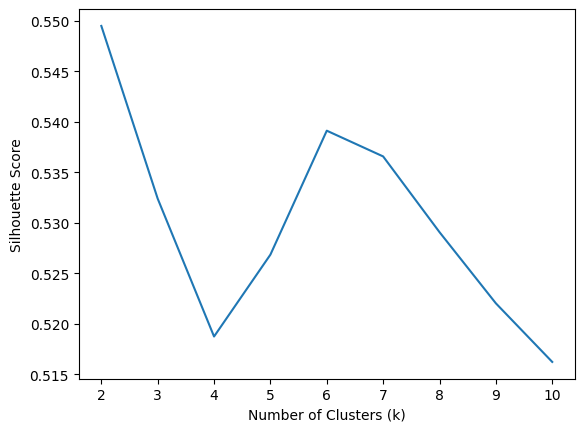

In [17]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

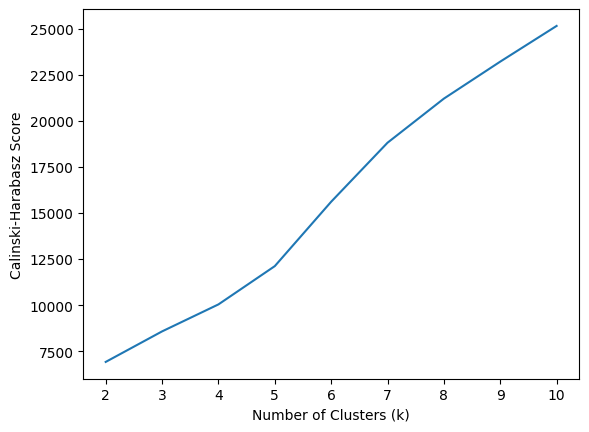

In [18]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

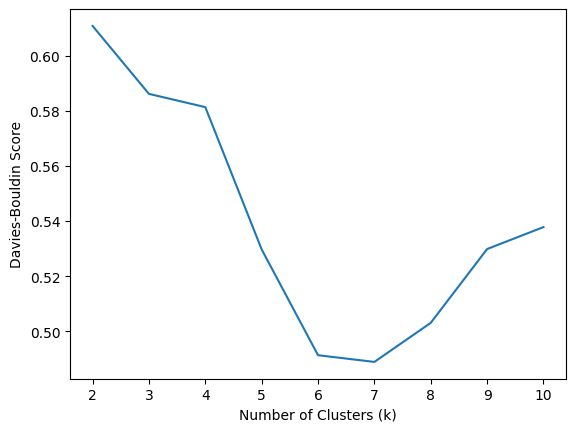

In [19]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

From above calculations and plotting, For K = 7 shows:
K: 7, Inertia: 6.454244035177215, Silhouette Score: 0.5334248073816413, Calinski-Harabasz score: 18736.176493148054, Davies-Bouldin score: 0.49549397471254736

1. Relatively **High Silhoutte score** of 0.53342 compared to the max value 0.54947.
2. Relatively **High Calinski-Harabasz score** of 18736.17649 with max value being 23789.62453.
3. **Low Davies-Bouldin score** of 0.49549 as compared to the max 0.61080 value.

**OBSERVATION: Thus K-Means clustering algorithm shows the network can be clustered into 7 clusters convincingly.**

********************************************************************************

**2. 2, 3 hops Mean neighbor Centrality Measure.**

1. 2 Hop mean neighbor centrality: measures how well-connected a node is within its extended 2-hop neighborhood. A Higher value indicates that the node's immediate neighbors are themselves well-connected.

2. 3-Hop Mean Neighbor Centrality: Similar to the 2-hop version, but it extends the calculation to include the neighbors of the node's neighbors' neighbors (three hops away). This provides a broader view of connectivity within a larger network region surrounding the node.

In [17]:
import numpy as np
import pandas as pd

def calculate_hops_vectorized(nodes, hops):
    result = []
    for node in nodes:
        neighbors_within_hops = nx.ego_graph(nx_graph, node, radius=hops)
        subgraph = nx_graph.subgraph(neighbors_within_hops)
        degrees = np.array(list(dict(subgraph.degree()).values()))
        result.append(degrees.mean())
    return result

In [ ]:
# Calculate node features
df_nodes_1 = pd.DataFrame({'Node': list(nx_graph.nodes())})

df_nodes_1['Two_Hops_Centrality'] = calculate_hops_vectorized(df_nodes_1['Node'], 2)
df_nodes_1['Three_Hops_Centrality'] = calculate_hops_vectorized(df_nodes_1['Node'], 3)

print(df_nodes_1.describe())

Above table shows us:
1. Maximum 2 Hop and 3 Hop centrality measures are 81.43 and 67.79 respectively.

  With Average values being 43.16 (higher than median) and 44.03 (much higher than median), this shows that more number of users in this network are well-connected with their neighbor on both the hops (distances).

2. Additionally proven by the point that 75% users have very high 2 and 3 hop centrality measures, thus showing users are well-connected at these distances.

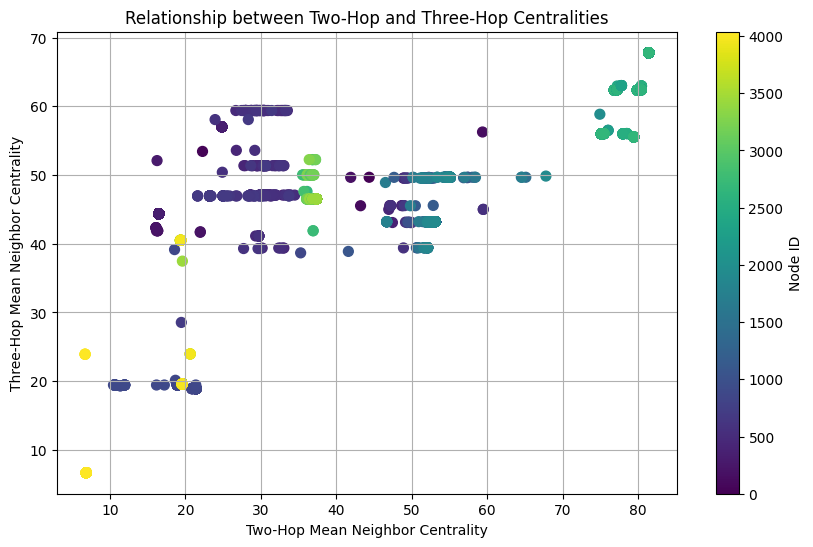

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_nodes_1['Two_Hops_Centrality'], df_nodes_1['Three_Hops_Centrality'],
            c=df_nodes_1['Node'], cmap='viridis', s=50)

plt.xlabel('Two-Hop Mean Neighbor Centrality')
plt.ylabel('Three-Hop Mean Neighbor Centrality')
plt.title('Relationship between Two-Hop and Three-Hop Centralities')
plt.colorbar(label='Node ID')
plt.grid(True)
plt.show()

The above plot shows:
1. The network can be clustered as these groups:

  1a. Group A: Contains users that are low on both centrality measures (lower left area of the plot). This group contains some outliers.

  1b. Group B: Users with low 2-Hop centrality, but high 3-Hop centrality. Shows that more umber of users are well-connected with their immediate neighbors than others extended neighbors.

  1c. Group C: Users who are well-connected on both the hops. These users are connected to extended neighbors equally as to their immediate neighbors. These includes some outliers too.

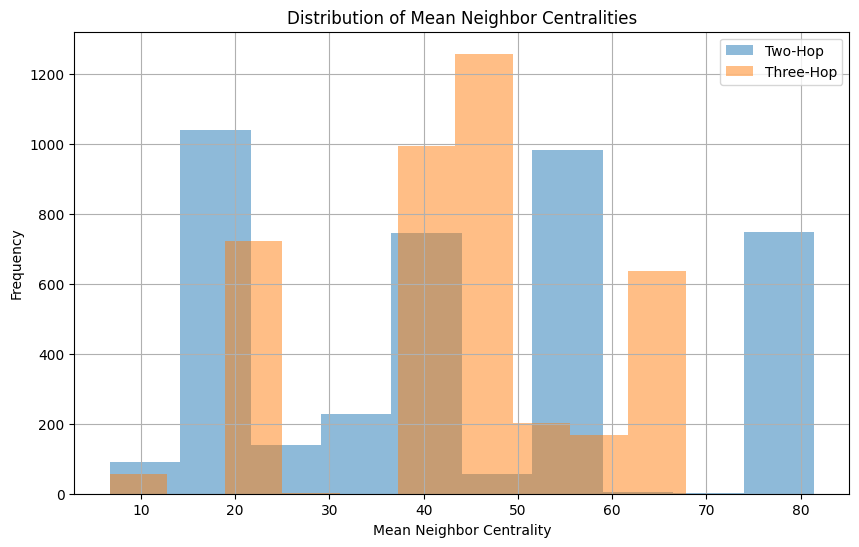

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_nodes_1['Two_Hops_Centrality'], alpha=0.5, label='Two-Hop')
plt.hist(df_nodes_1['Three_Hops_Centrality'], alpha=0.5, label='Three-Hop')

plt.xlabel('Mean Neighbor Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Neighbor Centralities')
plt.legend()
plt.grid(True)
plt.show()

Observation:
1. Above histogram plot shows that both the 2-Hop and 3-Hop neighbor centrality measure follow multimodal distribution.

2. More users in the network are well-conneted to their 2,3 hops neighbors than those who are not.

3. Both 2, 3-hop histograms have multiple peaks: It could suggest the presence of distinct communities within the network, each with its own characteristic level of connectivity.

Next, lets corroborate this observation by using K-Means algorithm.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2, Inertia: 1375601181.67463, Silhouette Score: 0.6261364468643815, Calinski-Harabasz score: 12085.711963459606, Davies-Bouldin score: 0.5008404505059607


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 3, Inertia: 611431205.7503812, Silhouette Score: 0.5896320977291016, Calinski-Harabasz score: 16113.889039903916, Davies-Bouldin score: 0.5013816950550022


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4, Inertia: 344539912.9693552, Silhouette Score: 0.5706900775358175, Calinski-Harabasz score: 20102.182768640065, Davies-Bouldin score: 0.5019369586098837


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5, Inertia: 220785918.8299815, Silhouette Score: 0.5593236841967714, Calinski-Harabasz score: 24086.493096058064, Davies-Bouldin score: 0.5024871917806737


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 6, Inertia: 153179041.13744593, Silhouette Score: 0.5523671344114828, Calinski-Harabasz score: 28123.62585405401, Davies-Bouldin score: 0.5018082158858601


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7, Inertia: 113026546.07591945, Silhouette Score: 0.5464821479895076, Calinski-Harabasz score: 31994.230511115347, Davies-Bouldin score: 0.5051709482409128


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 8, Inertia: 86688313.6922636, Silhouette Score: 0.5413453834271854, Calinski-Harabasz score: 35923.02736813994, Davies-Bouldin score: 0.5041432999281106


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9, Inertia: 68365088.43000704, Silhouette Score: 0.539903234699112, Calinski-Harabasz score: 39981.89058905776, Davies-Bouldin score: 0.5042465557316693


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 10, Inertia: 55733334.40999587, Silhouette Score: 0.5341949293407535, Calinski-Harabasz score: 43686.66581373025, Davies-Bouldin score: 0.5075105539829637


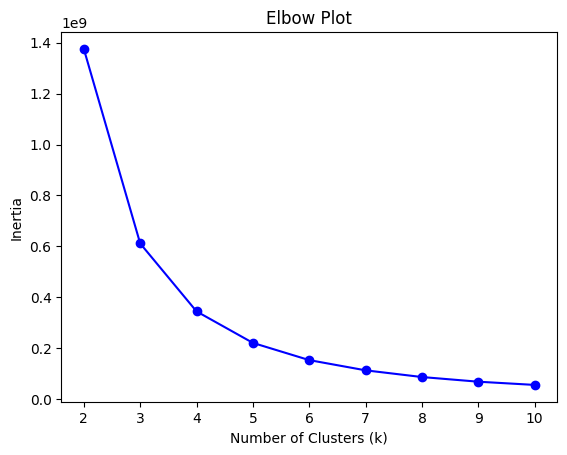

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
for k in range(2, 11):  # Check for k from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_nodes_1)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(df_nodes_1, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(df_nodes_1, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(df_nodes_1, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(df_nodes_1, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(df_nodes_1, labels)}, Davies-Bouldin score: {davies_bouldin_score(df_nodes_1, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

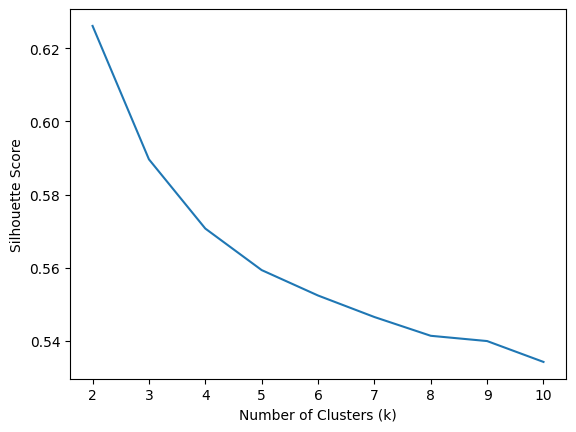

In [17]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

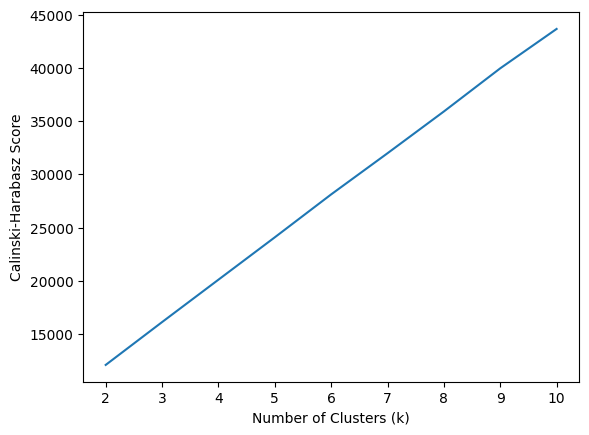

In [18]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

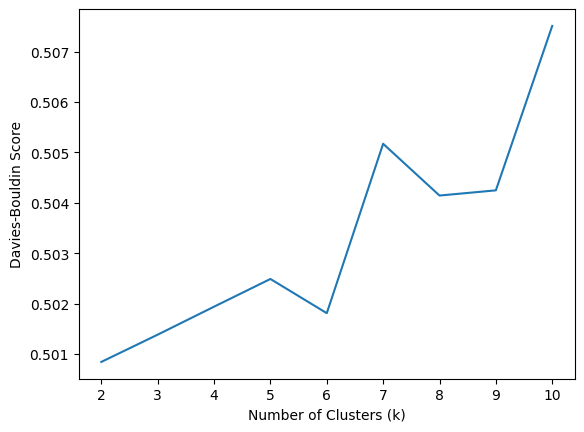

In [19]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

From above score measures, Clusters k = 4 shows a good balance of high Silhouette Score (above 0.5), High Calinski-Harabasz Score and relatively low Davies-Bouldin Score.

Thus, corroborating our earlier observation that clustering into 3 groups was a good solution based on the neighborhood measures.

**OBSERVATION: 2, 3 Hop centrality measures cluster the network into 4 Clusters.**

********************************************************************************

Next, Let's look at

**3. Eigen Vector Centrality Measure and Ego Graph measure**: Clusters based on how "Well-connected" a user is within the social network. Helps to use clusters for "Influencer Identification" business requirement.

In [6]:
import pandas as pd

# Calculate node features
eigenVector_centrality = nx.eigenvector_centrality(nx_graph)

# Create DataFrame
df_nodes_2 = pd.DataFrame({
    'Node': list(nx_graph.nodes()),
    'EigenVector_Centrality': [eigenVector_centrality[node] for node in nx_graph.nodes()],
    'Ego_Graph_Measure': [len(nx.ego_graph(nx_graph, node)) for node in nx_graph.nodes()]
})

print(df_nodes_2.describe())


              Node  EigenVector_Centrality  Ego_Graph_Measure
count  4039.000000            4.039000e+03        4039.000000
mean   2019.000000            3.864341e-03          44.691013
std    1166.103197            1.525485e-02          52.420605
min       0.000000            6.385265e-14           2.000000
25%    1009.500000            5.388575e-08          12.000000
50%    2019.000000            8.885652e-07          26.000000
75%    3028.500000            3.266349e-05          58.000000
max    4038.000000            9.540696e-02        1046.000000


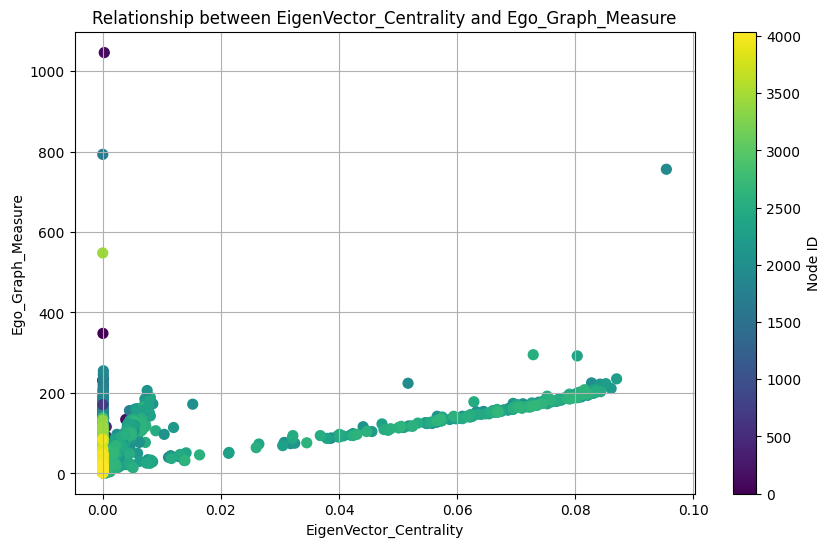

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_nodes_2['EigenVector_Centrality'], df_nodes_2['Ego_Graph_Measure'],
            c=df_nodes_2['Node'], cmap='viridis', s=50)

plt.xlabel('EigenVector_Centrality')
plt.ylabel('Ego_Graph_Measure')
plt.title('Relationship between EigenVector_Centrality and Ego_Graph_Measure')
plt.colorbar(label='Node ID')
plt.grid(True)
plt.show()

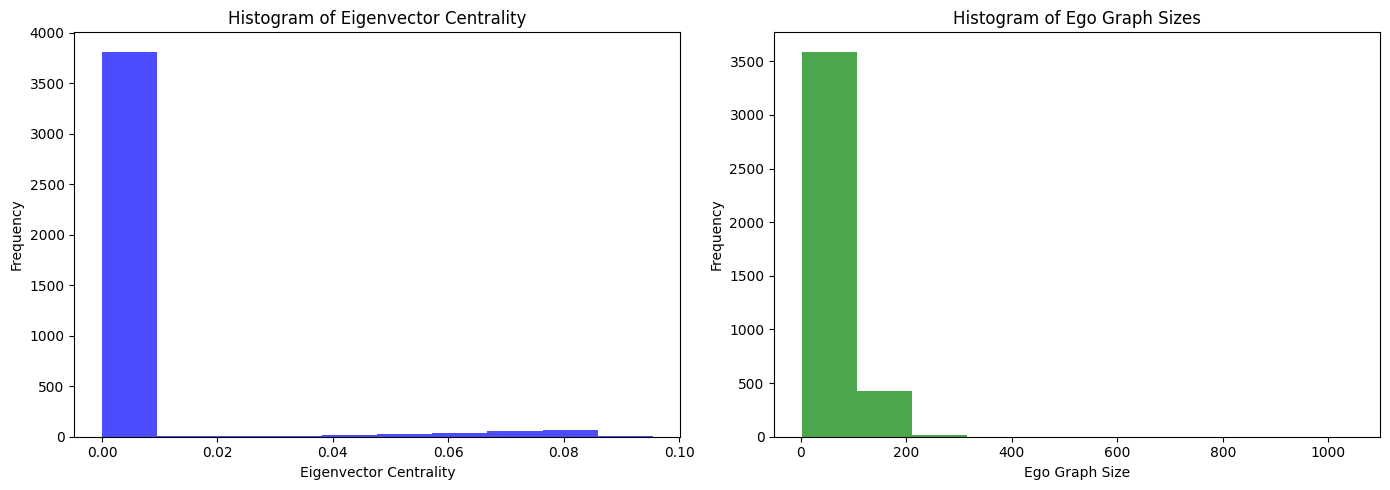

In [10]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram for eigenvector centrality
axs[0].hist(df_nodes_2['EigenVector_Centrality'], bins=10, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Eigenvector Centrality')
axs[0].set_xlabel('Eigenvector Centrality')
axs[0].set_ylabel('Frequency')

# Plot histogram for ego graph sizes
axs[1].hist(df_nodes_2['Ego_Graph_Measure'], bins=10, color='green', alpha=0.7)
axs[1].set_title('Histogram of Ego Graph Sizes')
axs[1].set_xlabel('Ego Graph Size')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

The range of values for Eigen Vector centrality is 0 to 1.
and the range for Ego Graph measure is 0 to N - 1, where N is number of nodes.

From above calculations and plots, it is clear that the majority of users are not connected to 'influential' users within the entire social network.

Both the histogram plots show users are skewed towards low eigen vector measures and low Ego graph measures.

<Figure size 1000x600 with 0 Axes>

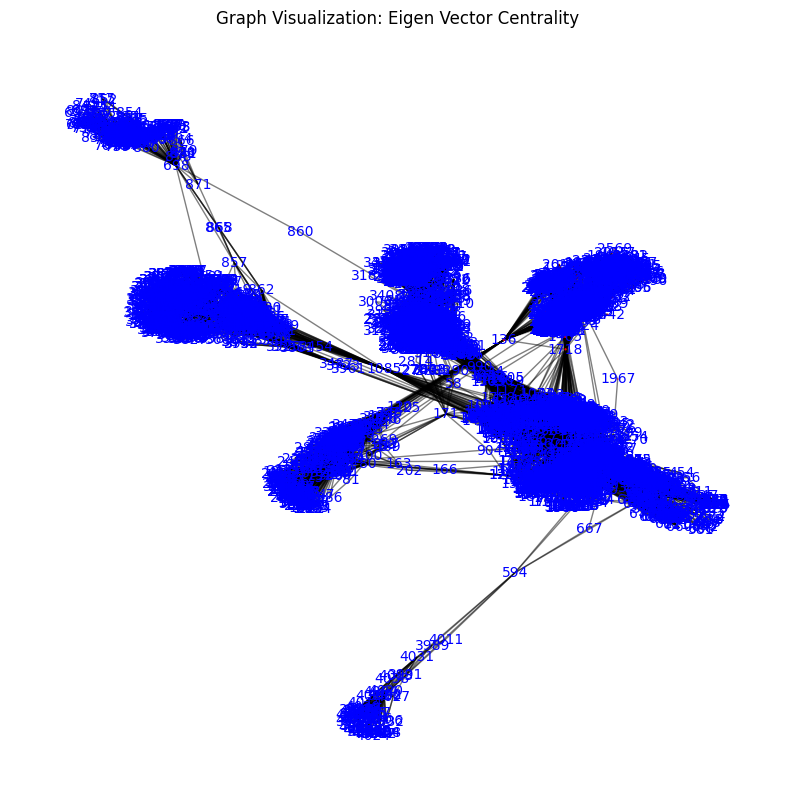

In [13]:
#Plot eigenVector_centrality  measures
plot_centrality_distribution(eigenVector_centrality, "Eigen Vector Centrality")

Above plot shows 7 clusters based on the node's and their eigen vector centrality measures.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2, Inertia: 1383808665.4179564, Silhouette Score: 0.623474717547899, Calinski-Harabasz score: 12014.01852441534, Davies-Bouldin score: 0.5035149538961484


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 3, Inertia: 619721387.7241249, Silhouette Score: 0.584181972440108, Calinski-Harabasz score: 15898.164406687813, Davies-Bouldin score: 0.5092948868255428


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4, Inertia: 352989035.40427864, Silhouette Score: 0.5623732445011433, Calinski-Harabasz score: 19620.182739780957, Davies-Bouldin score: 0.5156798738801011


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5, Inertia: 229335821.49935773, Silhouette Score: 0.5474235955656145, Calinski-Harabasz score: 23188.551790195757, Davies-Bouldin score: 0.521291605064466


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 6, Inertia: 161920931.29682082, Silhouette Score: 0.5366373509684826, Calinski-Harabasz score: 26603.477637132262, Davies-Bouldin score: 0.527990018579326


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7, Inertia: 121643596.68804428, Silhouette Score: 0.5265465748845419, Calinski-Harabasz score: 29725.252385557225, Davies-Bouldin score: 0.5368276650669942


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 8, Inertia: 95205065.17514443, Silhouette Score: 0.5183573444502719, Calinski-Harabasz score: 32706.00719196322, Davies-Bouldin score: 0.5410084991270516


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9, Inertia: 77069860.12944809, Silhouette Score: 0.5113317035678159, Calinski-Harabasz score: 35462.14829525899, Davies-Bouldin score: 0.5508757957013337


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 10, Inertia: 64389071.51462096, Silhouette Score: 0.5032401378249214, Calinski-Harabasz score: 37814.147743753776, Davies-Bouldin score: 0.5570229672366708


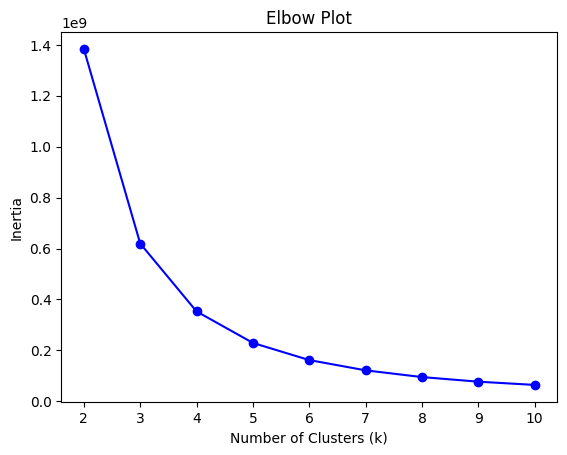

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
for k in range(2, 11):  # Check for k from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_nodes_2)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(df_nodes_2, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(df_nodes_2, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(df_nodes_2, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(df_nodes_2, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(df_nodes_2, labels)}, Davies-Bouldin score: {davies_bouldin_score(df_nodes_2, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

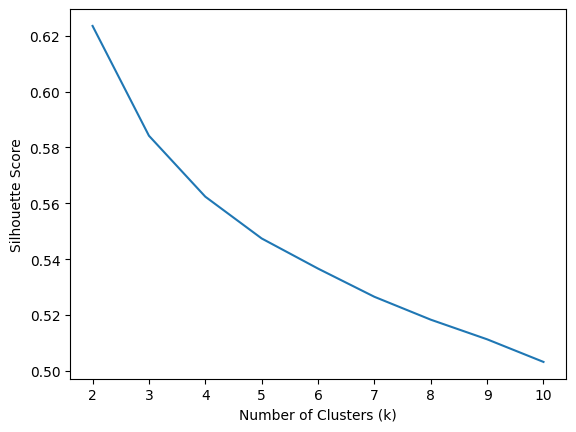

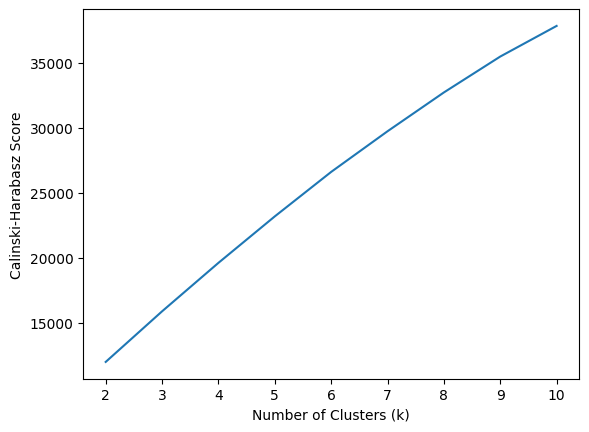

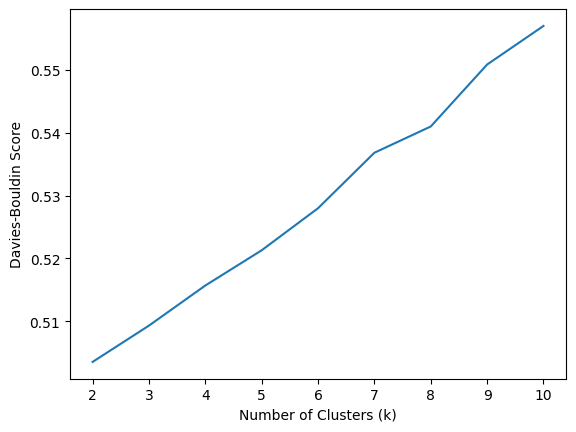

In [15]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

These plots and scores don't help in deducing the appropriate clusters as we have seen from the earlier plots of skewedeness towards low eigen vector and ego graph values.

Technically, as per the Elbow plot and scores,

**Observation: cluster = 7 balances with high Silhoutte score (above 0.5 threshold), high Calinski-Harabasz Score and low Davies-Bouldin Score and slowness in rate of change of Inertia values.**

********************************************************************************

**4. Finally, Combine all above measures** and cluster the social network to understand how different are clustering results when used together.

In [16]:
merged_df = pd.merge(df_nodes_1, df_nodes_2, on='Node')
merged_df = pd.merge(merged_df, df_nodes, on='Node')
merged_df.describe()

NameError: name 'df_nodes_1' is not defined

********************************************************************************

**Modelling #2: Node2vec**

Next, Let's use Node2vec algorithm to analyse this data set and deduce graph clustering.

Node2vec algorithm performs random walks on the graph to generate a vector representation of the nodes called embeddings. These embeddings are the  generated Features that are utilized for clustering.

These embeddings are vectors that we will use to cluster using K-Means and measure the performance by using the score measures that we used above.

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Learn embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get node embeddings
embeddings = model.wv

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

In [ ]:
#View the embeddings
print(embeddings.vectors.shape)
df = pd.DataFrame(embeddings.vectors, index=embeddings.key_to_index.keys())
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(df.describe())

(4039, 64)
              0          1          2          3          4          5   \
count 4039.00000 4039.00000 4039.00000 4039.00000 4039.00000 4039.00000   
mean     0.32006   -0.41092    0.52136   -0.10334    0.01765   -0.49349   
std      0.40535    0.32251    0.34891    0.32832    0.32433    0.33285   
min     -0.85486   -1.37167   -0.43342   -1.12542   -1.00415   -1.34199   
25%      0.02089   -0.65607    0.26715   -0.32985   -0.20304   -0.76199   
50%      0.37652   -0.39390    0.53250   -0.11745    0.01183   -0.48658   
75%      0.61891   -0.17712    0.76444    0.11141    0.23391   -0.23778   
max      1.47678    0.75262    1.72467    1.33961    1.05724    0.71391   

              6          7          8          9          10         11  \
count 4039.00000 4039.00000 4039.00000 4039.00000 4039.00000 4039.00000   
mean    -0.16093   -0.22092   -0.10666   -0.13655    0.30592   -0.07666   
std      0.39526    0.35989    0.38059    0.44897    0.34802    0.32465   
min     -1.45

K: 2, Inertia: 29950.12109375, Silhouette Score: 0.12768808007240295, Calinski-Harabasz score: 523.0811585845013, Davies-Bouldin score: 2.754716771193467
K: 3, Inertia: 26721.330078125, Silhouette Score: 0.16424891352653503, Calinski-Harabasz score: 536.9149148834028, Davies-Bouldin score: 2.1850238911837434
K: 4, Inertia: 25457.9609375, Silhouette Score: 0.12989535927772522, Calinski-Harabasz score: 442.356327955195, Davies-Bouldin score: 2.0760941749065402
K: 5, Inertia: 22201.7109375, Silhouette Score: 0.1886570155620575, Calinski-Harabasz score: 528.2456442989534, Davies-Bouldin score: 1.9661786700512232
K: 6, Inertia: 21140.712890625, Silhouette Score: 0.18804459273815155, Calinski-Harabasz score: 484.177859999268, Davies-Bouldin score: 1.9312485729305824
K: 7, Inertia: 18776.998046875, Silhouette Score: 0.22638390958309174, Calinski-Harabasz score: 538.7560152031219, Davies-Bouldin score: 1.7502210895673684
K: 8, Inertia: 18526.23046875, Silhouette Score: 0.20701462030410767, Cal

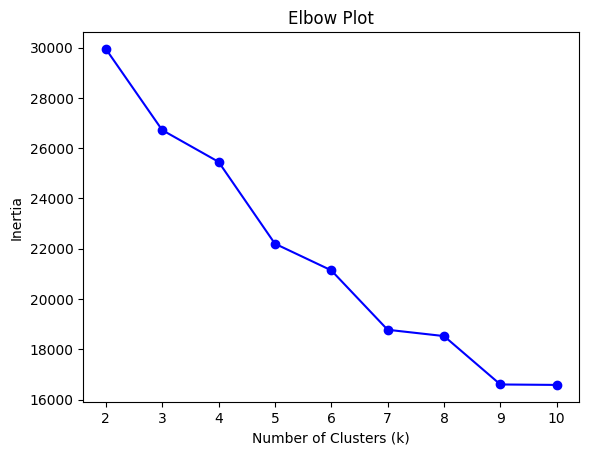

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Convert KeyedVectors to a NumPy array
embedding_array = embeddings.vectors

for k in range(2, 11):  # Check for k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embedding_array)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(embedding_array, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(embedding_array, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(embedding_array, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(embedding_array, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(embedding_array, labels)}, Davies-Bouldin score: {davies_bouldin_score(embedding_array, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

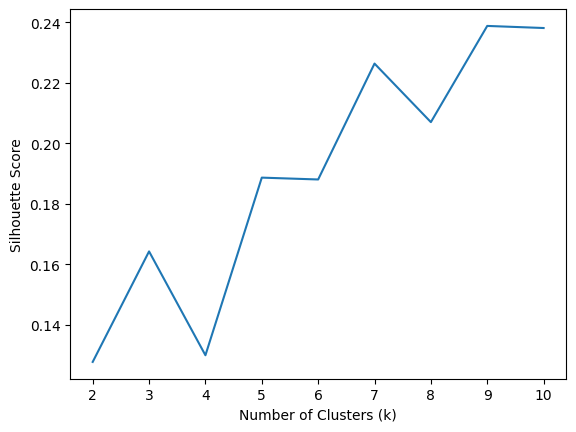

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

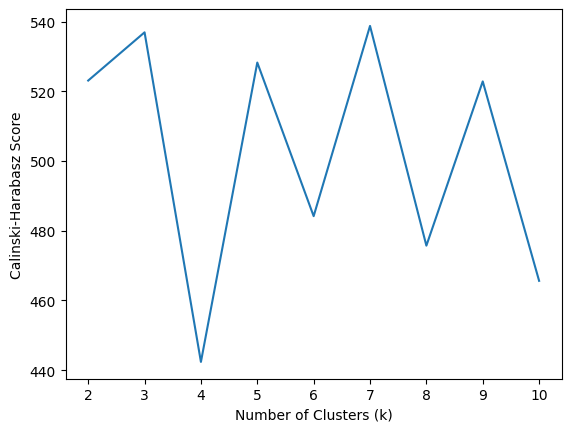

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

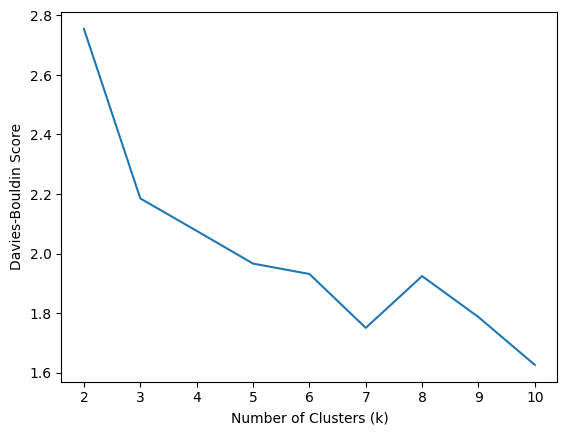

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

--> Above plots and scores indicate that **node2vec algorithm is not an effective algorithm to cluster this graph.**
The **scores are much below **the Threshold that we saw earlier using the K-Means algorithm.




We will additionally validate this observation by plotting the T-SNE results that reduces the dimensionality and a 2D plot below.

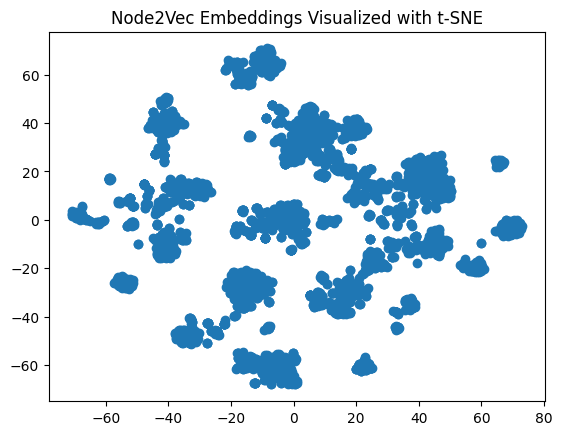

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np # Import numpy for array manipulation

nodes = list(embeddings.key_to_index.keys())
embedding_values = [embeddings[node] for node in nodes]

# Convert list of arrays to a 2D numpy array
embedding_values = np.array(embedding_values)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embedding_values)

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('Node2Vec Embeddings Visualized with t-SNE')
plt.show()

The plot shows multiple clusters and thus it's difficult to deduce that clusters size with this plot.

**Modelling #3: Hierarchical Algorithm**

In [ ]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Compute shortest path distances between all pairs of nodes
distances = squareform(pdist(nx.to_numpy_array(nx_graph)))

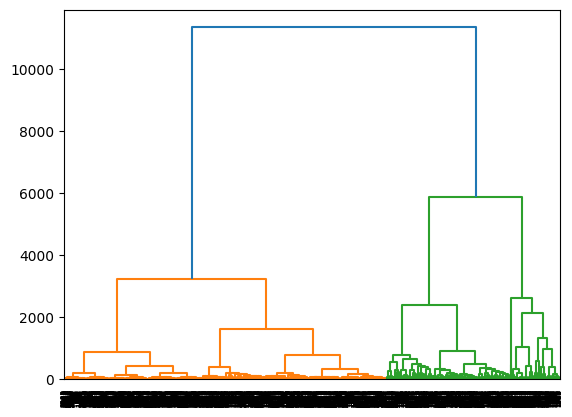

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(distances, method='ward')

# Plot the dendrogram
plt.figure()
dendrogram(Z)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Hierarchical clustering
# Cut the dendrogram to obtain 7 clusters
k = 7
clusters = fcluster(Z, k, criterion='maxclust')


# Calculate the Silhouette Score
silhouette_scores.append(silhouette_score(distances, clusters))
# Calculate the Calinski-Harabasz Score
calinski_harabasz_scores.append(calinski_harabasz_score(distances, clusters))
# Calculate the Davies-Bouldin Score
davies_bouldin_scores.append(davies_bouldin_score(distances, clusters))

print(f"K: {k}, Silhouette Score: {silhouette_score(distances, clusters)}, Calinski-Harabasz score: {calinski_harabasz_score(distances, clusters)}, Davies-Bouldin score: {davies_bouldin_score(distances, clusters)}")


K: 7, Silhouette Score: 0.4196500747695253, Calinski-Harabasz score: 7371.080899736827, Davies-Bouldin score: 0.7798348121465235


K: 7, Silhouette Score: 0.4196500747695253, Calinski-Harabasz score: 7371.080899736827, Davies-Bouldin score: 0.7798348121465235

**Modelling #4: DBSCAN Algorithm.**

DBSCAN algorithm helps in clustering graph with irregular shapes.
It designates outliers as noises and indicates them with label = -1 value.
Each DBSCAN on the graph data returns with clusters information that can be used for business objectives.

Below we calculate the distance between the users using Euclidean distance and then run the DBSCAN algorithm on the matrix.

In [ ]:
from sklearn.metrics import pairwise_distances

# Get the largest connected component for simplicity
largest_cc = max(nx.connected_components(nx_graph), key=len)
subgraph = nx_graph.subgraph(largest_cc)
adj_matrix = nx.to_numpy_array(subgraph)

# If you want to use shortest path distances instead:
# Fill diagonal with zeros for correct distance calculations
np.fill_diagonal(adj_matrix, 0)
distance_matrix = pairwise_distances(adj_matrix, metric='euclidean')

In [ ]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(distance_matrix)

[[ 0.         18.22086716 18.41195264 ... 18.68154169 18.734994
  18.86796226]
 [18.22086716  0.          5.         ...  4.35889894  4.58257569
   5.09901951]
 [18.41195264  5.          0.         ...  3.46410162  3.74165739
   4.35889894]
 ...
 [18.68154169  4.35889894  3.46410162 ...  0.          2.
   3.        ]
 [18.734994    4.58257569  3.74165739 ...  2.          0.
   2.64575131]
 [18.86796226  5.09901951  4.35889894 ...  3.          2.64575131
   0.        ]]


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

dbscan = DBSCAN(eps=10, min_samples=20, metric="precomputed")
labels = dbscan.fit_predict(distance_matrix)

# Counting clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("Labels:", labels)
print("Number of clusters:", n_clusters)


Labels: [-1  0  0 ...  0  0  0]
Number of clusters: 1


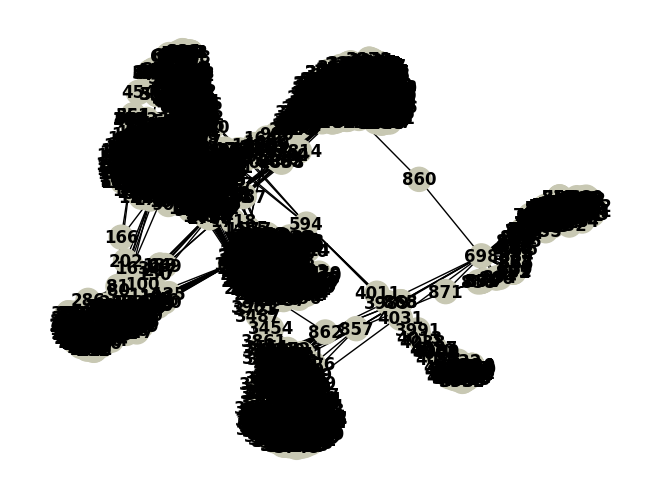

In [ ]:
import matplotlib.pyplot as plt

# Map the cluster labels to colors for visualization
color_map = {i: np.random.rand(3,) for i in np.unique(labels)}
node_colors = [color_map[label] for label in labels]

# Draw the graph with node colors based on clusters
nx.draw(subgraph, node_color=node_colors, with_labels=True, font_weight='bold')
plt.show()

The above plot shows 6 distinct clusters.

Measuring DBSCAN algorithm results:


In [ ]:
# Calculate the Silhouette Score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

score = silhouette_score(distance_matrix, labels, metric="precomputed")
print("Silhouette Score:", score)

Silhouette Score: 0.5520830025413554


In [ ]:

ch_index = calinski_harabasz_score(distance_matrix, labels)
print("Calinski-Harabasz Index:", ch_index)

Calinski-Harabasz Index: 296.44848384996016


In [ ]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(distance_matrix, labels)
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 0.6583625652709222


The Epsilon and minPts values can be identified by analysing the below K-distance plot.


K = 200 nearest neighbors are used to fit the the distance matrix on.

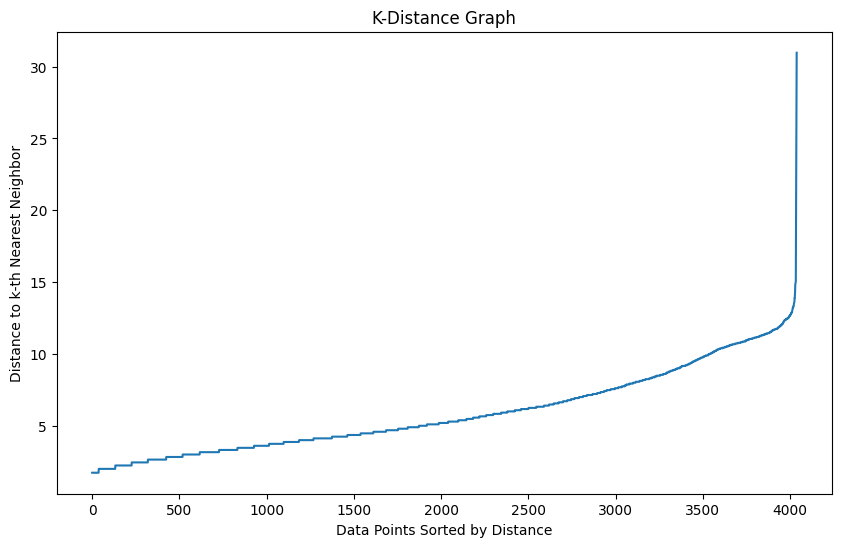

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calculate distances to k-th nearest neighbor (start with a higher k and adjust as needed)
k = 200
neighbors = NearestNeighbors(n_neighbors=k, metric='precomputed')
neighbors_fit = neighbors.fit(distance_matrix)
distances, indices = neighbors_fit.kneighbors(distance_matrix)

# Sort distances and plot them
distances = np.sort(distances, axis=0)
distances = distances[:, k-1]  # Extract distances to the k-th nearest neighbor

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('Distance to k-th Nearest Neighbor')
plt.show()

Employing additional clustering algorithms:

1. Mean-Shift Clustering.
2. Spectral Clustering.
3. Affinity Propagation.
4. OPTICS.

